# Tutorial

This is a tutorial for MB-MVPA using task-fMRI data of Mixed-gamble task by Tom et al., 2007. 



### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [1]:
from time import perf_counter

In [2]:
from mbmvpa.preprocessing.preprocess import DataPreprocessor

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


TODO: add original data download link

Data download from AWS S3, ~ <b>1GB</b> (would be under the "Mixed-gamble_task/example_data/").<br>

We provide a small subset (2 subjects) of original Tom's dataset (16 subjects). The fMRI images in the example is preprocessed by conventional fMRI preprocessing pipeline by using 
[*fmriprep*](https://fmriprep.org/en/stable/) v.20.1.0. Please refer to the [original](https://openneuro.org/datasets/ds000005/versions/00001) for more information.

In [2]:
#root = load_example_data("tom")
root = "/data2/project_modelbasedMVPA/ds000005"

### Preprocessing fMRI images and behavioral data

MB-MVPA requires primariliy preprocessed task-fMRI experiments data fromatted in conventional [BIDS format](https://bids-specification.readthedocs.io/en/stable/) 

It expects the following organized files. All the naming conventions used here conform with outputs from *fmriprep* v.20.1.0. by Poldrack lab.

The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

In [4]:
s = perf_counter()

dm_model = 'ra_prospect'

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.ra_prospect requirements ##
    row["gamble"] = 1 if row["respcat"] == 1 else 0
    row["cert"] = 0
    return row

def example_filter(row):
    # include all trial data
    return True

def example_latent(row, param_dict):
    ## calculate subjectives utility for choosing Gamble over Safe option
    ## prospect theory with loss aversion and risk aversion is adopted
    modulation = (row["gain"] ** param_dict["rho"]) - (param_dict["lambda"] * (row["loss"] ** param_dict["rho"]))
    row["modulation"] = modulation
    return row


preprocessor = DataPreprocessor(bids_layout=root,
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               latent_function=example_latent,
                               dm_model=dm_model,
                               high_pass=None,
                               detrend=False,
                               smoothing_fwhm=6,
                               confunds=[],
                               zoom=(2,2,2))
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.49 minutes


In [5]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


In [6]:
s = perf_counter()

#preprocessor.preprocess(overwrite=True,core=16)
#preprocessor.preprocess(overwrite=False,core=16)
#feature_name = 'voxelfeaturemasked'
preprocessor.X_generator.run(overwrite=True)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

12it [03:01, 15.16s/it]

elapsed time: 3.15 minutes


In [7]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: .../ds000005/derivatives/fmriprep | Subjects: 16 | Sessions: 0 | Runs: 48
[  MB-MVPA   ] BIDS Layout: ...PA/ds000005/derivatives/mbmvpa | Subjects: 16 | Sessions: 0 | Runs: 48


### Load data and shape check

In [2]:
from mbmvpa.data.loader import BIDSDataLoader

In [3]:
root = "/data2/project_modelbasedMVPA/ds000005"

In [4]:
s = perf_counter()

#loader = BIDSDataLoader(layout=root,feature_name=feature_name)
loader = BIDSDataLoader(layout=root)
X,y = loader.get_data(subject_wise=False)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


elapsed time: 0.18 minutes


In [5]:
print("X", X.shape)
print("y", y.shape)

X (11520, 2236)
y (11520, 1)


In [6]:
voxel_mask = loader.get_voxel_mask()

### Fitting MVPA models & Results

In [7]:
from mbmvpa.models.mvpa_mlp import MLP

In [8]:
MVPA_model = MLP(X=X,
                y=y,
                save=False,
                layer_dims=[1024,1024],
                activation='relu',
                n_patience=20,
                n_repeat=10,
                voxel_mask = voxel_mask)



In [11]:
s = perf_counter()

coeffs = MVPA_model.run()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

[001] - score: 0.2673 p: 0.0000
[002] - score: 0.2260 p: 0.0000
[003] - score: 0.2510 p: 0.0000
[004] - score: 0.3007 p: 0.0000
[005] - score: 0.1951 p: 0.0000
[006] - score: 0.2453 p: 0.0000
[007] - score: 0.2135 p: 0.0000
[008] - score: 0.2164 p: 0.0000
[009] - score: 0.2031 p: 0.0000
[010] - score: 0.2235 p: 0.0000
elapsed time: 12.79 minutes


In [9]:
#loader = BIDSDataLoader(layout=root)
X_dict,y_dict = loader.get_data(subject_wise=True)

[000] - score: 0.2955 p: 0.0000
[001] - score: 0.2670 p: 0.0000
[002] - score: 0.2682 p: 0.0000
[003] - score: 0.2598 p: 0.0000
[004] - score: 0.3059 p: 0.0000


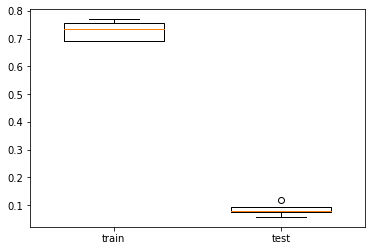

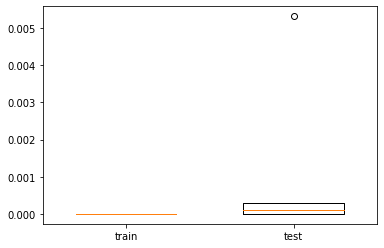

In [10]:
metrics_train, metrics_test = MVPA_model.run_crossvalidation(X_dict,
                                                     y_dict,
                                                     method='5-fold')

[000] - score: 0.2422 p: 0.0000
[001] - score: 0.2574 p: 0.0000
[002] - score: 0.2432 p: 0.0000
[003] - score: 0.2579 p: 0.0000
[004] - score: 0.2379 p: 0.0000
[005] - score: 0.3012 p: 0.0000
[006] - score: 0.2284 p: 0.0000
[007] - score: 0.2298 p: 0.0000
[008] - score: 0.2275 p: 0.0000
[009] - score: 0.2601 p: 0.0000
[010] - score: 0.1973 p: 0.0000
[011] - score: 0.2497 p: 0.0000
[012] - score: 0.2759 p: 0.0000
[013] - score: 0.2806 p: 0.0000
[014] - score: 0.2443 p: 0.0000
[015] - score: 0.2431 p: 0.0000


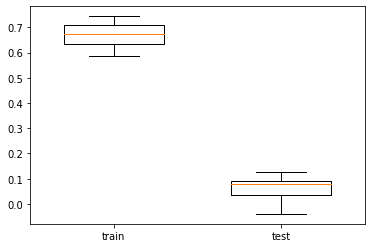

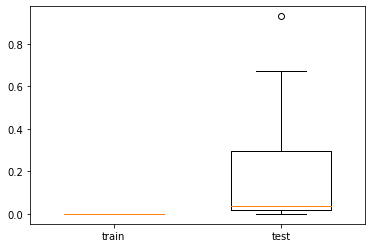

In [11]:
metrics_train, metrics_test = MVPA_model.run_crossvalidation(X_dict,
                                                             y_dict,
                                                             method='loso')

In [16]:
import matplotlib.pyplot as plt

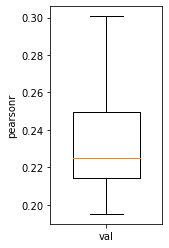

In [20]:
plt.figure(figsize=(2,4))
plt.boxplot([MVPA_model._scores], labels=['val'], widths=0.6)
plt.ylabel('pearsonr')
plt.show()

In [13]:
MVPA_model._scores

array([0.267348  , 0.22604434, 0.2510146 , 0.3006729 , 0.19510661,
       0.24528714, 0.21351196, 0.21640993, 0.20305595, 0.22349575])

In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[1024,1024],
                dropout_rate=0.5,
                activation='relu',
                n_patience=15,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


[001] - score: 0.1284 p: 0.0000
[002] - score: 0.0825 p: 0.0002
[003] - score: 0.0648 p: 0.0038
[004] - score: 0.0831 p: 0.0002
[005] - score: 0.0973 p: 0.0000
[006] - score: 0.0618 p: 0.0057
[007] - score: 0.1088 p: 0.0000
[008] - score: 0.0875 p: 0.0001
[009] - score: 0.0322 p: 0.1498


In [20]:
loader.X['01'].shape

(3, 240, 119)

In [39]:
loader.y['01']

array([[[-4.32794235e-01],
        [-3.89169994e-01],
        [-3.00324509e-01],
        [-2.28450031e-01],
        [-1.77000037e-01],
        [-3.00687854e-01],
        [-5.68269364e-01],
        [-6.84215141e-01],
        [-6.15771625e-01],
        [-4.97551177e-01],
        [-2.77357446e-01],
        [ 3.98899884e-02],
        [ 8.49647919e-02],
        [ 3.30830936e-02],
        [ 1.56096039e-01],
        [ 2.04289661e-01],
        [ 1.60034527e-01],
        [-5.45465648e-02],
        [-3.43113959e-01],
        [-5.24413467e-01],
        [-4.56810465e-01],
        [-1.84086829e-01],
        [ 4.79595553e-02],
        [ 2.19509513e-01],
        [ 2.73854517e-01],
        [ 3.08613512e-01],
        [ 1.21010373e-01],
        [ 3.19815963e-02],
        [ 3.06189159e-01],
        [ 3.47393857e-01],
        [ 9.41800572e-02],
        [-2.36720648e-01],
        [-3.42086153e-01],
        [-1.45484064e-01],
        [-1.00827883e-01],
        [-2.79198534e-01],
        [-4.61477344e-01],
 

In [28]:
MVPA_model = MLP(X=loader.X['01'].reshape(-1,119),
                y=loader.y['01'].reshape(-1,),
                layer_dims=[1024,1024],
                dropout_rate=0.5,
                activation='relu',
                n_patience=30,
                learning_rate=0.001,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


[001] - score: 0.2204 p: 0.0080
[002] - score: 0.2488 p: 0.0026
[003] - score: 0.1554 p: 0.0629
[004] - score: 0.1400 p: 0.0942
[005] - score: 0.1212 p: 0.1479
[006] - score: 0.1497 p: 0.0734
[007] - score: 0.2114 p: 0.0110
[008] - score: 0.2333 p: 0.0049
[009] - score: 0.1827 p: 0.0284
[010] - score: 0.2459 p: 0.0030


In [31]:
import matplotlib.pyplot as plt

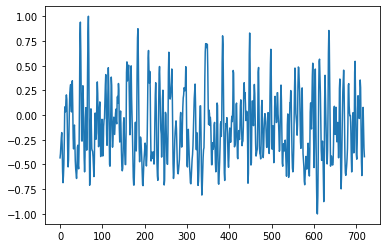

In [35]:
plt.plot(loader.y['01'][:80].reshape(-1,))

In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[256,256],
                activation='relu',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[256],
                activation='relu',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[256,128,64,32],
                dropout_rate=0.1,
                activation='relu',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[1024,1024],
                dropout_rate=0.5,
                activation='relu',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[2048,2048],
                dropout_rate=0.5,
                activation='relu',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[1024,1024],
                dropout_rate=0.5,
                activation='relu',
                n_patience=10,
                learning_rate=0.01,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
MVPA_model = MLP(X=X,
                y=y,
                layer_dims=[1],
                dropout_rate=0.0,
                activation='linear',
                n_patience=10,
                n_repeat=10,
                voxel_mask = voxel_mask)

coeffs = MVPA_model.run()


In [ ]:
s = perf_counter()

sham_errors = MVPA_model.sham()

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

In [ ]:
img = MVPA_model.image(save_path='.', task_name='example')